## Image Animations
When we modify the content of an image at a sufficient rate, we cannot track the individual scenes but instead get the impression of continuous *motion*. So the primarey differency between still image and movie is that the movie has many images in a given time while the still image has only one. 

The number of images per second is called image frequency, or very often *frame-rate*, and a *frame* describes the individual items we show (or process) and can be used in other contextes as well.

Physiologically the frame-rate needs to be between 20 to 25 Hz (images per second) to create the motion impression. Technically we aim for values like 25, 30, 50 or 60 Hz which corresponds to the electrical grid frequencies in non-US and US countries (50 or 60 Hz resp.)

Note there is also a movie style called *stop-motion* which uses a frame-rate so low, that we can still see images. This can create interesting effects too. 

To create a (very simple) movie we have to update our image source frequently enough and merge the images into a video file format. 


In [16]:
# First step is to load all required modules
import numpy as np
# this time we use the "notebook" style to import matplotlib
# as we need some interactive features
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# we use some skimage features again
# see http://www.scipy-lectures.org/advanced/image_processing/index.html#basic-image
from skimage import color, filters, data, transform
from skimage.transform import rescale, resize, rotate, downscale_local_mean

import os

# numba is just for the last animation
from numba import jit
import numpy as np

<IPython.core.display.Javascript object>


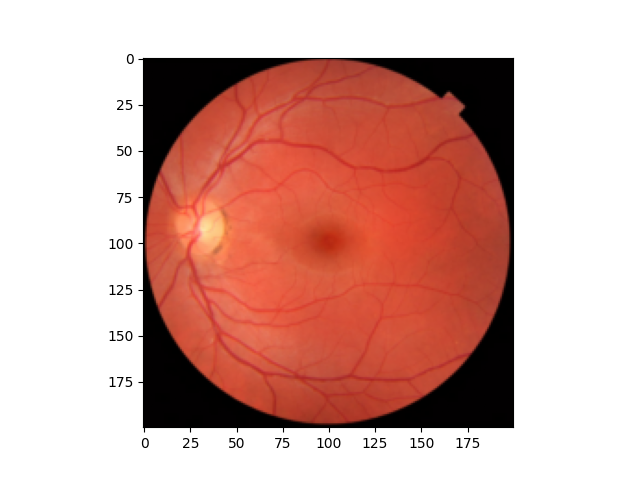

In [17]:
# We use on of the default images that comme with skimage and adjust it to our needs
# retina is a large image so re resize it
im0 = data.retina()
im = transform.resize(im0,(200,200))

plt.imshow(im)
#plt.show()

## Changing image content
A simple way to modify the image content is a rotation of the data. We rotate by a number of pixels which is derived from the function parameter *f*. f will later be set by the animation process and is the frame index. Rotating the image is done by the numpy function *roll()*.

Note, we don't modify the image *im*, we just rotate it by an offset when we update the canvas.

To actually change the image content we have to use the *set_data* function of the image object, which basically represents the drawing area (or canvas).

We can also update the title and other features of the figure.


In [18]:
# rotate function, offset is the frame number
def rot(f):
    # we need title and img as global variables
    # as we have to modify them
    # We could ommit this line if all variables were defined before this function
    # don't rely on that ..
    global img, title
    title.set_text(f"Frame {f:3d}")
    img.set_data(np.roll(im,f,1))
    return img


## Animation setup
We need to create a figure with a subplot as in some previous examples. We show the image once, with the *animated*Ture* option (not required in notebook mode).

Then we create an animation object which uses the the figure and the function to display a number of frames after a call to the update function. The interval is given in ms.

You can stop the animation with the button in the top right corner of the video frame.

**Make sure you're running with %matplotlib notebook**


<IPython.core.display.Javascript object>


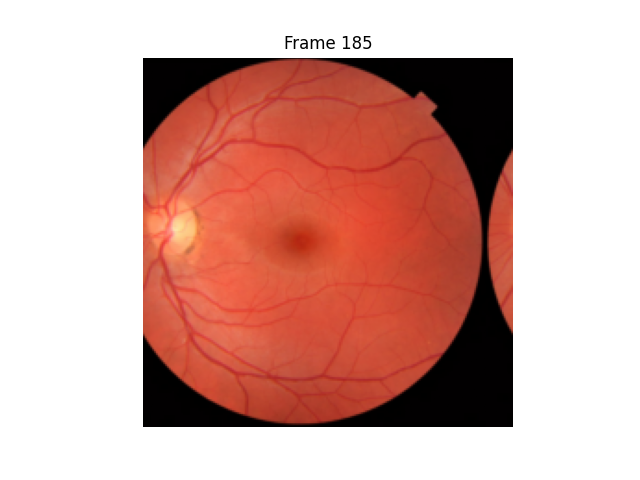

In [19]:
fig = plt.figure("Simple Animation")
ax = fig.add_subplot()
title = ax.set_title("Result")
ax.axis('off')
img = plt.imshow(im, animated=True) 

ani = animation.FuncAnimation(fig, rot, interval=200, frames=im.shape[0] + 20, blit=True)

## Video file
We can save the animation to disk using the *save* method of the animation.


In [20]:
# we save and load the image in the same fashion as before
# but we use "png" format which gives a better quality for the
# next chapter
TARGET_DIR = "data"
# if the directory doesn't exist, we create it
if not TARGET_DIR in os.listdir():
    os.mkdir(TARGET_DIR)
    
file = "video1.mp4"
videoFile = os.path.sep.join([TARGET_DIR,file])

# this might fail with a message like 
#    MovieWriter ffmpeg unavailable; using Pillow instead.
# If that happens on your local Jupyter, try to install FFMPEG
# On binder or another remote Jupyter change the extenstion from .mp4 to .gif
# this will at least generat an animation

ani.save(videoFile)

## Complex Animation
Finally we create an animation where a completely new image is generated for every frame. For this, we use one of the mathematical operations well-known for nice visualization features - the *Julia set*, see [https://en.wikipedia.org/wiki/Julia_set](https://en.wikipedia.org/wiki/Julia_set)

Without going to deep into the math, the Julia set is a 2D region in the complex space and every X/Y location is iteratively analyzed for a certain property. This maps perfectly onto a 2D image where every pixel gets a color depending on the outcome of the iterative computation. 

This animation program is essentially the same as the ones above. However, the iterative algorithm is very timeconsuming and slow with base Python. To improve this, we use the *numba* library, which provides a *just in time compiler* (JIT) which enables faster and parallel code execution. Just comment the line 

> @jit

in front of the *julia_numba* function definition and you will see the difference.


<IPython.core.display.Javascript object>


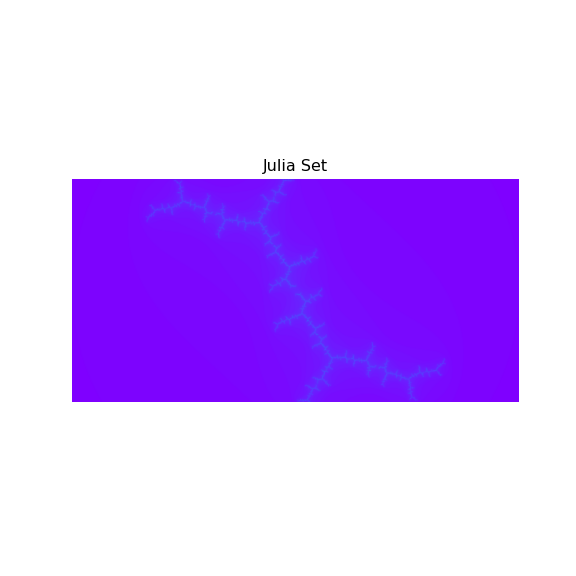

In [21]:
# We need to define the size of the julia set first. 
# Actual dimensions will be N*2N
N = 512
# Some other constants to control the image
DPI = 96
WIDTH = 1+ N//DPI
HEIGHT = 1+ N//DPI
# initialize real and imaginary parts for the julia function
CREAL = -0.835
CIMAG = - 0.2321


# then we create a color map for the iteration results
# We use a predefined rainbow map but you could create your own custom map too
cmap = np.empty((N,3),dtype=np.uint8)
for i in range(256):
    cmap[i] = np.dot(plt.cm.rainbow(i)[0:3],255)

###################################
# this is the actual julia set computation function
# Note, the @jit line enables the numba speed-up
@jit
def julia_numba(N,cr,ci):
    T = np.empty((N, 2*N), dtype=np.uint8)
    # for some reason the code does not work if we use just the
    # second array (TC) and a simple point as accumulator
    TC = np.empty((N, 2*N,3), dtype=np.uint8)
        
    h = 2.0/N
    for J in range(N):
        for I in range(2*N):
            zimag = -1.0 + J*h
            zreal = -2.0 + I*h
            T[J,I] = 0
            zreal2 = zreal*zreal
            zimag2 = zimag*zimag
            while (zimag2 + zreal2 <= 4) and (T[J,I] < 255):
                zimag = 2* zreal*zimag + ci
                zreal = zreal2 - zimag2 + cr
                zreal2 = zreal*zreal
                zimag2 = zimag*zimag 
                T[J,I] += 1
            # update tc
            TC[J,I] = cmap[T[J,I]]
                
    return TC


#########################
# main part
# we create the figure
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT),dpi=DPI)
title = ax.set_title("Julia Set")
ax.axis('off')
# and initialize the canvas with an empty array of the same size N*2N
# we have to declare this before the animation function
img = plt.imshow(np.empty((N, 2*N), dtype=np.uint8), animated=True) 

#########################
# animation function, like in the previous examples
# creates a new image based upon the parameter t
def nextJulia(t):
    global img
    print(t)
    z = julia_numba(N, CREAL + t/100 , CIMAG - t/100)
    img.set_data(z)
    return z 


# this setups and calls the animation (without jupyter, you will need to call the animation)
ani = animation.FuncAnimation(fig, nextJulia, interval=100, frames=100, blit=True)


## Summary
We have seen how to create an animated image sequence with matplotlib and how to save it to a movie file. 
The video quality is not impressive, but there are more features available for the movie writer in matplotlib as well as other libraries like *moviepy* which allow more control over the process.

We also used a more complex animation function to create an entirely new image per frame.
